In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Intro to `pyAgrum`
*Optimal decisions on graphs*


A part of [CausalPython](https://causalpython.io) series on causality.

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=150 align="left"></a>
<br>

## Create the environment


To run this notebook use `causal_xplor_23`.

To create: `conda env create -f causal-xplor-23.yml`

## Create our first `BayesNet`

In [42]:
# Create and name the object
net = gum.BayesNet('NorthernWinter')

In [43]:
# Add nodes
season = net.add(
    gum.LabelizedVariable(
        'season',
        'Season',
        ['Winter', 'Summer']
    )
)

outside_temp = net.add(
    gum.LabelizedVariable(
        'outside_temp',
        'Temperature outside',
        ['Low', 'High']
    )
)

heating = net.add(
    gum.LabelizedVariable(
        'heating',
        'Is indoor heating on?',
        ['No', 'Yes']
    )
)

dry_skin = net.add(
    gum.LabelizedVariable(
        'dry_skin',
        'Is my skin dry?',
        ['No', 'Yes']
    )
)

In [44]:
# Add edges
for edge in [
    (season, outside_temp),
    (season, heating),
    (outside_temp, heating),
    (outside_temp, dry_skin),
    (heating, dry_skin)
]:
    net.addArc(*edge)

In [45]:
net

(pyAgrum.BayesNet<double>@000001E07CEBA4B0) BN{nodes: 4, arcs: 5, domainSize: 16, dim: 11, mem: 176o}

## Add probability tables

In [50]:
# P(Season=Winter)
net.cpt('season').fillWith([0.65, 0.35])

# P(Temp|Season)
net.cpt('outside_temp')[:] = [
    [0.95, 0.05],
    [0.35, 0.65]
]

# P(Heating|Season, Temp)
net.cpt('heating')[{'season': 'Winter', 'outside_temp': 'Low'}] = [0.02, 0.98]
net.cpt('heating')[{'season': 'Winter', 'outside_temp': 'High'}] = [0.1, 0.9]
net.cpt('heating')[{'season': 'Summer', 'outside_temp': 'Low'}] = [0.9, 0.1]
net.cpt('heating')[{'season': 'Summer', 'outside_temp': 'High'}] = [0.9999, 0.0001]

# P(DrySkin|Temp, Heating)
net.cpt('dry_skin')[{'outside_temp': 'Low', 'heating': 'No'}] = [0.001, 0.999]
net.cpt('dry_skin')[{'outside_temp': 'Low', 'heating': 'Yes'}] = [0.099, 0.901]
net.cpt('dry_skin')[{'outside_temp': 'High', 'heating': 'No'}] = [0.89, 0.11]
net.cpt('dry_skin')[{'outside_temp': 'High', 'heating': 'Yes'}] = [0.9, 0.1]

In [54]:
net.cpt('dry_skin')

(pyAgrum.Potential<double>@000001E07D891E90) 
             ||  dry_skin         |
outsid|heatin||No       |Yes      |
------|------||---------|---------|
Low   |No    || 0.0010  | 0.9990  |
High  |No    || 0.8900  | 0.1100  |
Low   |Yes   || 0.0990  | 0.9010  |
High  |Yes   || 0.9000  | 0.1000  |

## Inference

### No evidence

In [56]:
# Initialize the inference engine
inf_engine = gum.LazyPropagation(net)

In [57]:
# Make inferences without evidence
inf_engine.makeInference()

In [58]:
# Check posterior
inf_engine.posterior('dry_skin')

(pyAgrum.Potential<double>@000001E07D891AD0) 
  dry_skin         |
No       |Yes      |
---------|---------|
 0.2929  | 0.7071  |

### With evidence

In [59]:
# Set evidence
inf_engine.setEvidence(
    {
        'season': 'Winter'
    }
)

# Make inference
inf_engine.makeInference()

# Check posterior
inf_engine.posterior('dry_skin')

(pyAgrum.Potential<double>@000001E07D891990) 
  dry_skin         |
No       |Yes      |
---------|---------|
 0.1371  | 0.8629  |

### Partial (probabilistic) evidence

In [61]:
# Set evidence
inf_engine.setEvidence(
    {
        'season': 'Winter',
        'heating': [.9, .1]
    }
)

# Make inference
inf_engine.makeInference()

# Check posterior
inf_engine.posterior('dry_skin')

(pyAgrum.Potential<double>@000001E07D891EF0) 
  dry_skin         |
No       |Yes      |
---------|---------|
 0.1450  | 0.8550  |

## Inference over the entire network

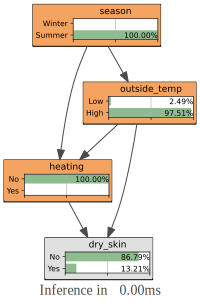

In [63]:
gnb.showInference(
    net,
    evs={
        'season': 'Summer',
        'heating': 'No',
        'outside_temp': [.05, .95]
    }
)